##### DDPG == Deep Deterministic Policy Gradient

DDPG의 기본 개념:       

Actor: 상태를 받아서 어떤 연속적인 행동을 할지 출력         
Critic: (s, a) 쌍에 대한 Q-value를 예측         
Deterministic: 행동이 확률이 아니라 **정확히 정해짐** -> Actor는 a = μ(s) 형태           
Target Network: 안정적인 학습을 위한 복사본 네트워크         
Replay Buffer: 경험을 재사용하기 위해서 저장하는 메모리       

#### 핵심 구조:           

1. Actor: 상태 -> 행동       
- 현재 상태 s를 확인, policy 네트워크가 a = μ(s) 형태

2. Critic: s-a -> 평가
- Critic 네트워크 Q(s, a)를 예측
- 선택한 행동이 얼마나 좋은지 **판단**

3. 저장: Replay Buffer
- (s, a, r, s') 저장

4. 업데이트
- Mini-batch를 꺼내서 Q-network(Critic) 업데이트
- Actor는 **Q값이 최대가 되는 방향**으로 파라미터 조정

5. Target Network soft update
- 느리게 업데이트 
- DQN보다 안정적


In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque

In [2]:
print(torch.cuda.is_available())

False


In [3]:
env = gym.make("Pendulum-v1")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
# Actor: 현재 상태를 입력받아 행동을 출력하는 정책 네트워크

class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.out = nn.Linear(300, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return torch.tanh(self.out(x)) * max_action


# Critic: 상태랑 행동을 입력받아 Q값을 출력하는 가치 평가 네트워크

class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.out = nn.Linear(300, 1)

    def forward(self, x, u):
        x = torch.cat([x, u], 1) # 1 == dim == 열방향 == 가로로
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.out(x)


In [33]:
class ReplayBuffer:
    def __init__(self, size = 1000000):
        self.buffer = deque(maxlen=size)
    def add(self, transition):
        self.buffer.append(transition)  # (state, action, reward, next_state, done) = (s, a, r, s', True)
    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*samples))
        return (
            torch.FloatTensor(state).to(device),
            torch.FloatTensor(action).to(device),
            torch.FloatTensor(reward).unsqueeze(1).to(device),
            torch.FloatTensor(next_state).to(device),
            torch.FloatTensor(done).unsqueeze(1).to(device)
        )
    
    def __len__(self):
        return len(self.buffer)

In [34]:
!pip show torch

Name: torch
Version: 2.5.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /opt/anaconda3/lib/python3.11/site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: thop, torchaudio, torchvision, ultralytics, ultralytics-thop


In [35]:
Actor().to(device).load_state_dict(Actor().to(device).state_dict())

<All keys matched successfully>

In [36]:

actor = Actor().to(device)
critic = Critic().to(device)
target_actor = Actor().to(device)
target_critic = Critic().to(device)
target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)
replay_buffer = ReplayBuffer()
gamma = 0.99
tau = 0.005
batch_size = 64
exploration_noise = 0.1

In [37]:
episode_rewards = []
critic_losses = []
def train():
    if len(replay_buffer) < batch_size:
        return
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    with torch.no_grad():
        target_action = target_actor(next_state)
        target_q = reward + (1 - done) * gamma * target_critic(next_state, target_action)
    currnet_q = critic(state, action)
    critic_loss = F.mse_loss(currnet_q, target_q)
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()
    critic_losses.append(critic_loss.item())
    actor_loss = -critic(state, actor(state)).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

    for param, target_param in zip(critic.parameters(), target_critic.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        
    for param, target_param in zip(actor.parameters(), target_actor.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

In [38]:
for episode in range(200):
    state, _ = env.reset()
    episode_reward = 0
    for t in range(200):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = actor(state_tensor).detach().cpu().numpy()[0]
        action = action + np.random.normal(0, exploration_noise, size=action_dim)
        action = np.clip(action, -max_action, max_action)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.add((state, action, reward, next_state, float(done)))
        state = next_state
        episode_reward += reward
        train()
        if done:
            break
    episode_rewards.append(episode_reward)
    print(f"Episode {episode+1}, Reward: {episode_reward:.2f}")

Episode 1, Reward: -1523.16
Episode 2, Reward: -1630.35
Episode 3, Reward: -1205.00
Episode 4, Reward: -1116.81
Episode 5, Reward: -1170.52
Episode 6, Reward: -1318.60
Episode 7, Reward: -971.14
Episode 8, Reward: -1438.71
Episode 9, Reward: -1078.26
Episode 10, Reward: -1240.34
Episode 11, Reward: -1353.16
Episode 12, Reward: -987.05
Episode 13, Reward: -1067.67
Episode 14, Reward: -1173.21
Episode 15, Reward: -1113.20
Episode 16, Reward: -919.93
Episode 17, Reward: -1182.89
Episode 18, Reward: -1215.53
Episode 19, Reward: -1397.89
Episode 20, Reward: -1236.31
Episode 21, Reward: -1272.69
Episode 22, Reward: -1224.08
Episode 23, Reward: -1217.48
Episode 24, Reward: -1337.89
Episode 25, Reward: -1313.68
Episode 26, Reward: -1053.95
Episode 27, Reward: -1207.74
Episode 28, Reward: -1216.57
Episode 29, Reward: -1023.02
Episode 30, Reward: -1041.78
Episode 31, Reward: -1036.43
Episode 32, Reward: -923.84
Episode 33, Reward: -1041.65
Episode 34, Reward: -1015.85
Episode 35, Reward: -1036.6

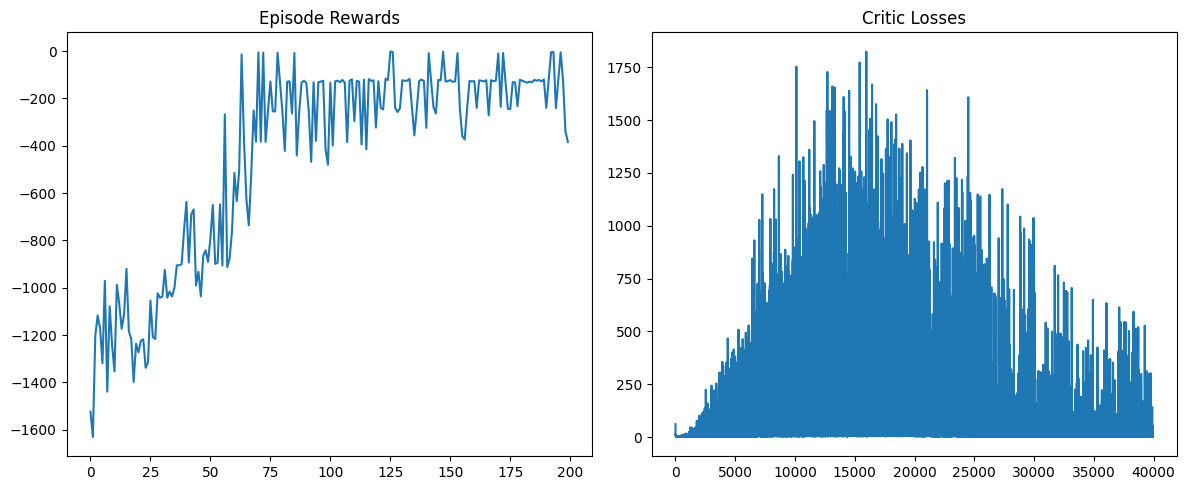

In [42]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title("Episode Rewards")

plt.subplot(1, 2, 2)
plt.plot(critic_losses)
plt.title("Critic Losses")

plt.tight_layout()
plt.show()

In [43]:
torch.save(actor.state_dict(), "ddpg_actor.pth")
torch.save(critic.state_dict(), "ddpg_critic.pth")


In [44]:
import time
import gym
import torch

env = gym.make("Pendulum-v1", render_mode="human")

actor.load_state_dict(torch.load("ddpg_actor.pth"))
actor.eval()

state, _ = env.reset()
for _ in range(200):
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    action - actor(state_tensor).detach().cpu().numpy()[0]
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    state = next_state
    time.sleep(0.02)

    if done:
        break
env.close()

/var/folders/49/kn3qtqw97dg7zskp6k1280xh0000gn/T/ipykernel_92639/277128586.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  actor.load_state_dict(torch.load("ddpg_actor.p